2022-03-17 Ludovico Massaccesi

In [1]:
from functools import partial
from itertools import combinations
from time import time
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from scipy.special import erfinv

# Measures of central tendency exercises
First of all, define the location estimators to be tested.

In [2]:
def a_inf(x):
    """The sample midrange."""
    return (x.min() + x.max()) / 2

def a_1(x):
    """The sample median."""
    idxs = np.argsort(x)
    ihalf = len(idxs) // 2
    if len(idxs) % 2 == 1:
        return x[idxs[ihalf]]
    return (x[idxs[ihalf-1]] + x[idxs[ihalf]]) / 2

def a_2(x):
    """The arithmetic mean."""
    return x.mean()

def a_ninf(x):
    """The sample mode, computed as the mean between the two
    samples closest to each other."""
    x = np.sort(x)
    d = x[1:] - x[:-1]
    imin = np.argmin(d)
    return (x[imin] + x[imin+1]) / 2

def mode_binned(x, bins=50, range=[-3, 3]):
    """The sample mode, computed as the highest bin of an
    histogram."""
    h, e = np.histogram(x, bins=bins, range=range)
    imax = np.argmax(h)
    return (e[imax] + e[imax+1]) / 2

def mode_range(x, w=0.1):
    """The sample mode, computed as the mid point of the
    w-wide (arbitrary) range that contains most of the
    samples."""
    n = (len(x) * (len(x) - 1)) // 2
    if 2*8*n > 4e9:  # Abort if it would allocate more than 4 GiB
        return np.nan
    x = np.sort(x)
    y = x + w  # Upper bounds of all the possible ranges
    i1 = np.arange(len(x))  # First indices of each range
    xx, yy = np.meshgrid(x, y, copy=False)
    i2 = np.argmin(np.abs(yy - xx), axis=1)
    i2 -= i1  # Number of samples in each interval
    return x[np.argmax(i2)] + w/2

def mode_half_range(x):
    """The sample mode, computed by recurively choosing
    the half-range that contains the most samples."""
    x = np.sort(x)
    l, u = x.min(), x.max()
    while len(x) > 2:
        h = (l+u) / 2
        i = (x>h).nonzero()[0]
        i = i[0] if len(i) else len(x)
        if i > len(x) - i:
            u = h
            x = x[:i]
        else:
            l = h
            x = x[i:]
    return (l+u) / 2

def mode_half_samples(x):
    """The sample mode, computed by recursively choosing
    the interval that contains half of the samples."""
    x = np.sort(x)
    while len(x) > 2:
        h = len(x) // 2
        d = x[h:] - x[:-h]
        i = np.argmin(d)
        x = x[i:i+h]
    return x.mean()

def hle(x):
    """The Hodges-Lehmann estimator."""
    n = (len(x) * (len(x) - 1)) // 2
    if 2*8*n > 4e9:  # Abort if it would allocate more than 4 GiB
        return np.nan
    # Make a matrix with all possible combinations
    x1, x2 = np.meshgrid(x, x, copy=False)
    # Take the triangle above the main diagonal
    idxs = np.triu_indices(len(x), 1)
    x1 = x1[idxs]
    x1 += x2[idxs]
    del x2
    x1 /= 2
    return a_1(x1)

def tm(x, r=0.1):
    """The truncated mean."""
    l = max(1, int(len(x) * r / 2))
    return np.sort(x)[l:-l].mean()

def wm(x, r=0.1):
    """The Windsorized mean."""
    l = int(len(x) * r / 2)
    x = np.sort(x)
    x[:l] = x[l]
    x[-l:] = x[-l-1]
    return x.mean()

In [3]:
ESTIMATORS = {
    "a∞/midrange": a_inf,
    "a1/median": a_1,
    "a2/mean": a_2,
    "a-∞ mode": a_ninf,
    #"binned mode": mode_binned,
    "range mode": mode_range,
    "half-range mode": mode_half_range,
    "half-samples mode": mode_half_samples,
    "Hodges-Lehman": hle,
    "truncated mean 10%": tm,
    "Windsor mean 10%": wm,
    "truncated mean 25%": partial(tm, r=0.25),
    "Windsor mean 25%": partial(wm, r=0.25)
}

Then, define the distributions.

In [4]:
def uniform(size):
    """Uniform distribution in [0, 1]."""
    return np.random.uniform(size=size)

def triangular(size):
    """Triangular distribution in [0, 2]."""
    return uniform(size) + uniform(size)

def gaussian(size):
    """Gaussian distribution with μ = 0 and σ = 1."""
    return np.sqrt(2) * erfinv(2 * uniform(size) - 1)

def d_gaussian(size):
    """Double gaussian: half of the samples with
    μ = 0 and σ = 1, the other half with μ = 0 and σ = 4."""
    s = gaussian(size)
    s[size//2:] *= 4
    return s

def exponential(size):
    """Exponential distribution with λ = 1."""
    return -np.log(1 - uniform(size))  # uniform() * (1-1e7) ?

def d_exponential(size):
    """Double exponential: half of the samples with
    λ = 1, the other half with λ = 4."""
    s = exponential(size)
    s[size//2:] *= 4
    return s

def cauchy(size):
    """Cauchy distribution with μ = 0 and Γ = 1."""
    return np.tan(np.pi * (uniform(size) - 0.5))

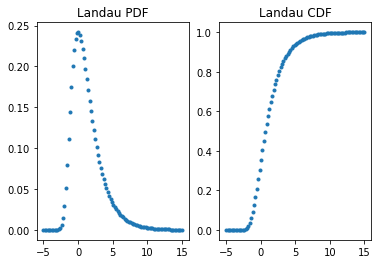

In [5]:
def landau_pdf(x):
    """Approximate PDF with μ = 0 and c = 1."""
    return np.exp(-(x + np.exp(-x)) / 2) / np.sqrt(2*np.pi)

# x, PDF and CDF values for interpolation
LANDAU_x = np.linspace(-5, 15, 100)
LANDAU_p = landau_pdf(LANDAU_x)
LANDAU_F = np.cumsum(LANDAU_p) * (LANDAU_x[1]-LANDAU_x[0])
# Graphical check that everything is fine
plt.subplot(121)
plt.plot(LANDAU_x, LANDAU_p, ".")
plt.title("Landau PDF")
plt.subplot(122)
plt.plot(LANDAU_x, LANDAU_F, ".")
plt.title("Landau CDF")
plt.show()

def landau_cdf_inv(f):
    """Interpolated from LANDAU_x and LANDAU_F."""
    return np.interp(f, LANDAU_F, LANDAU_x)

In [6]:
def landau(size, mu=0, c=1):
    """Landau distribution."""
    return mu + 2*c*np.log(c)/np.pi + c * landau_cdf_inv(uniform(size))

In [7]:
DISTRIBUTIONS = {  # name: (function, location_parameter)
    "uniform [0,1]": (uniform, 0.5),
    "triangular [0,2]": (triangular, 1),
    "Gaussian": (gaussian, 0),
    "double Gaussian": (d_gaussian, 0),
    "exponential": (exponential, 1),
    "double exponential": (d_exponential, 0.625),
    "Cauchy": (cauchy, 0),
    "Landau c=1": (landau, 0), #-0.429),  # MPV
    "Landau c=5": (partial(landau, c=5), 0)# -0.429*5)  # MPV
}

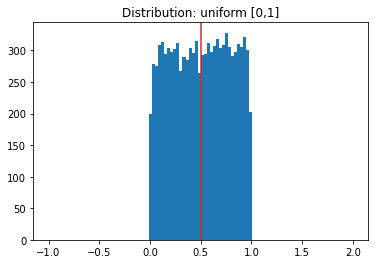

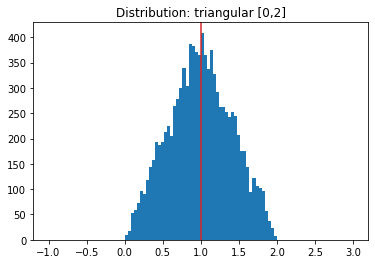

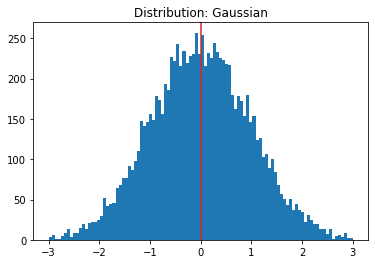

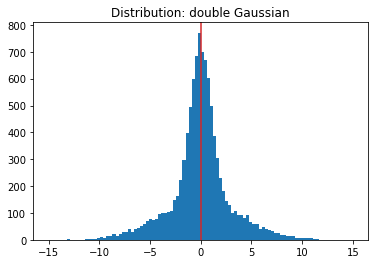

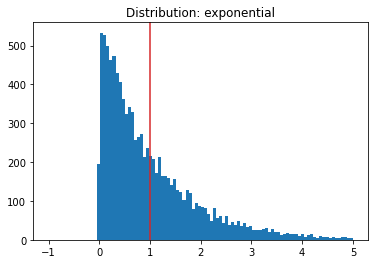

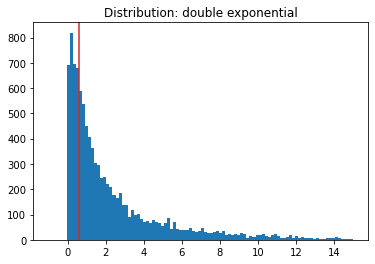

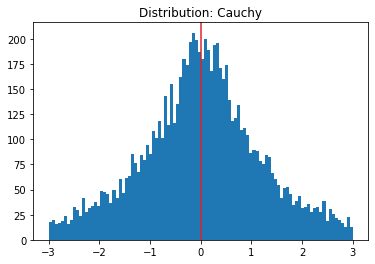

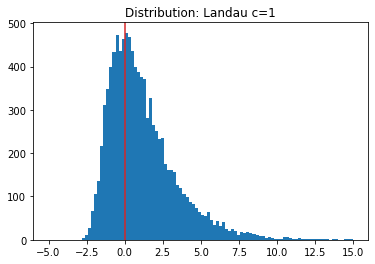

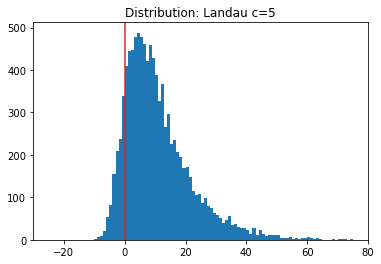

In [8]:
ranges = {
    "uniform [0,1]": [-1, 2],
    "triangular [0,2]": [-1, 3],
    "Gaussian": [-3, 3],
    "double Gaussian": [-15, 15],
    "exponential": [-1, 5],
    "double exponential": [-1, 15],
    "Cauchy": [-3, 3],
    "Landau c=1": [-5, 15],
    "Landau c=5": [-5*5, 15*5]
}
for dist_name, (dist, dist_center) in DISTRIBUTIONS.items():
    plt.figure()
    plt.hist(dist(int(1e4)), bins=100, range=ranges[dist_name])
    plt.title(f"Distribution: {dist_name}")
    plt.axvline(dist_center, c="tab:red")

And, finally, test the estimators.

In [9]:
def test_estimators(n_samples=100, repetitions=10):
    #print(f"{n_samples:d} samples, {repetitions:d} repetitions")
    d_var, d_bias, d_time, d_dt, d_res = {}, {}, {}, {}, {}
    for dist_name, (dist, dist_center) in DISTRIBUTIONS.items():
        est_results = {est_name: [] for est_name in ESTIMATORS.keys()}
        est_times = {est_name: [] for est_name in ESTIMATORS.keys()}
        for i in range(repetitions):
            samples = dist(n_samples)
            for est_name, est in ESTIMATORS.items():
                ts = time()
                est_results[est_name].append(est(samples))
                te = time()
                est_times[est_name].append(te - ts)
        #print()
        #print(f"===== Distribution: {dist_name} =====")
        #print(f"{'Estimator':20s} {'Variance':>10s} {'Bias':>10s} {'Time [μs]':10s}")
        d_var[dist_name] = {}
        d_bias[dist_name] = {}
        d_time[dist_name] = {}
        d_dt[dist_name] = {}
        d_res[dist_name] = {}
        for est_name in ESTIMATORS.keys():
            results = np.array(est_results[est_name])
            times = np.array(est_times[est_name])
            bias = a_1(results) - dist_center  # Using median
            var = results.var(ddof=1)
            t, dt = times.mean(), times.std(ddof=1)
            #print(f"{est_name:20s} {var:10.5f} {bias:10.5f} {t*1e6:5.0f} ± {dt*1e6:<5.0f}")
            d_var[dist_name][est_name] = var
            d_bias[dist_name][est_name] = bias
            d_time[dist_name][est_name] = t
            d_dt[dist_name][est_name] = dt
            d_res[dist_name][est_name] = results
    return d_var, d_bias, d_time, d_dt, d_res

In [10]:
def plot_results(d_var, d_bias, d_time, d_dt, d_res, title_suffix=""):
    for title, d in [("Variance", d_var), ("Bias (median of est. - μ)", d_bias), ("Time [s]", d_time)]:
        mat = np.array([list(x.values()) for x in d.values()])
        ylabels = list(d.keys())
        xlabels = list(next(iter(d.values())).keys())
        
        m = mat.copy()
        if "Time" not in title:
            i = ylabels.index("Cauchy")
            m[i,:] = 0
            i = ylabels.index("Landau c=5")
            m[i,:] = 0
        if "Bias" not in title:
            m = m[m>0]
        vmin, vmax = np.nanmin(m), np.nanmax(m)
        if "Bias" not in title:
            kwargs = {"norm": LogNorm(vmin=vmin, vmax=vmax)}
        else:
            kwargs = {"vmin": vmin, "vmax": vmax}

        plt.matshow(mat, **kwargs)
        plt.colorbar()
        plt.title(title + title_suffix)
        
        plt.gca().xaxis.set_ticks_position('bottom')
        plt.gca().set_xticks(list(range(len(xlabels))))
        plt.gca().set_xticklabels(xlabels)
        plt.xticks(rotation=90)
        
        plt.gca().set_yticks(list(range(len(ylabels))))
        plt.gca().set_yticklabels(ylabels)
        
        for x in range(len(xlabels)):
            for y in range(len(ylabels)):
                if not (vmin <= mat[y,x] <= vmax):
                    s = f"{mat[y,x]:.2g}"
                    if "e" in s:
                        s = f"{mat[y,x]:.0e}".replace("+", "").replace("0", "")
                    plt.text(x, y, s, c="r", va="center", ha="center")

Run the test assuming different numbers of samples.

In [11]:
res = {}
for i in [10, 20, 50, 100, 200, 500, 1000, 2000, 5000]:  #, 10000, 20000, 50000]:
    r = max(10000 // i, 100)
    print(f"Computing with {i} samples and {r} repetitions...")
    %time res[i] = test_estimators(i, r)

Computing with 10 samples and 1000 repetitions...
CPU times: user 2.89 s, sys: 3.27 ms, total: 2.9 s
Wall time: 2.9 s
Computing with 20 samples and 500 repetitions...
CPU times: user 1.5 s, sys: 0 ns, total: 1.5 s
Wall time: 1.5 s
Computing with 50 samples and 200 repetitions...
CPU times: user 869 ms, sys: 3.71 ms, total: 873 ms
Wall time: 872 ms
Computing with 100 samples and 100 repetitions...
CPU times: user 771 ms, sys: 0 ns, total: 771 ms
Wall time: 771 ms
Computing with 200 samples and 100 repetitions...
CPU times: user 2.13 s, sys: 0 ns, total: 2.13 s
Wall time: 2.13 s
Computing with 500 samples and 100 repetitions...
CPU times: user 13 s, sys: 1.9 s, total: 14.9 s
Wall time: 14.9 s
Computing with 1000 samples and 100 repetitions...
CPU times: user 55.7 s, sys: 5.1 s, total: 1min
Wall time: 1min
Computing with 2000 samples and 100 repetitions...
CPU times: user 4min 14s, sys: 13.1 s, total: 4min 27s
Wall time: 4min 27s
Computing with 5000 samples and 100 repetitions...
CPU time

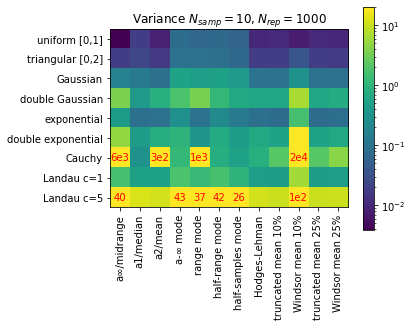

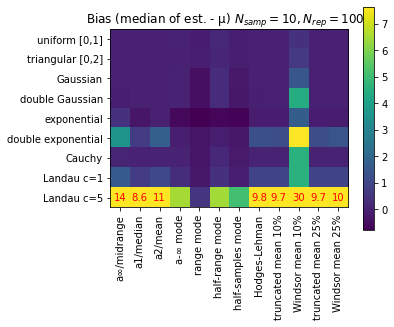

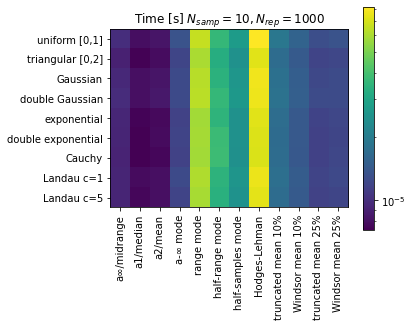

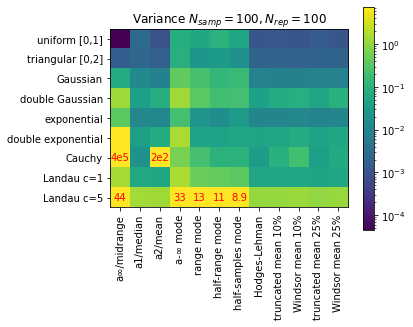

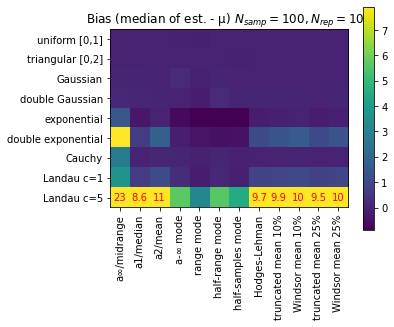

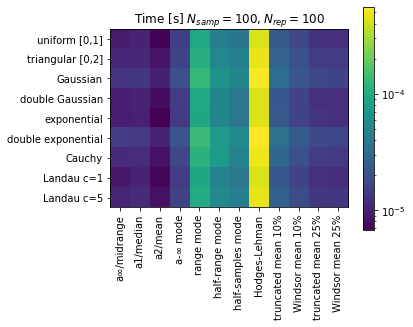

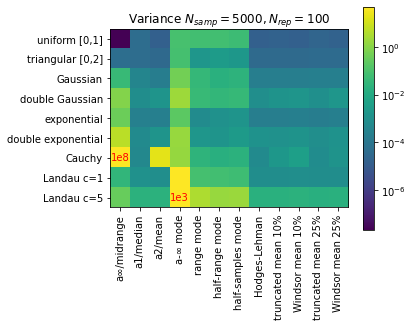

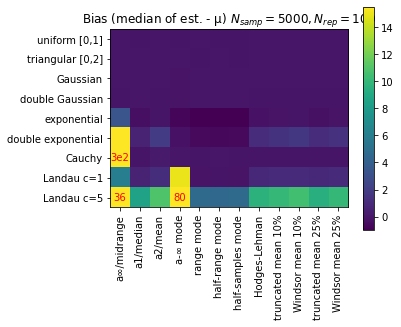

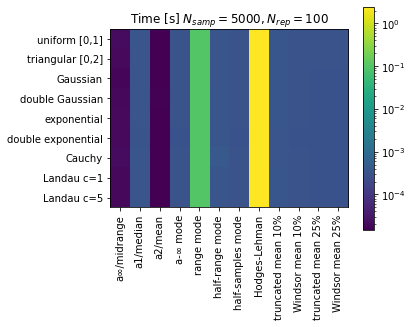

In [16]:
for n_samp in [10, 100, 5000]:
    results = res[n_samp]
    r = max(10000 // n_samp, 100)
    plot_results(*results, f" $N_{{samp}}={n_samp:g}, N_{{rep}}={r:g}$")
    plt.show()

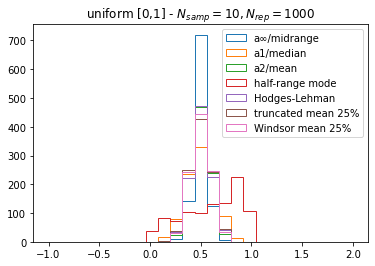

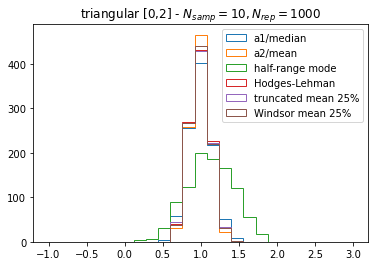

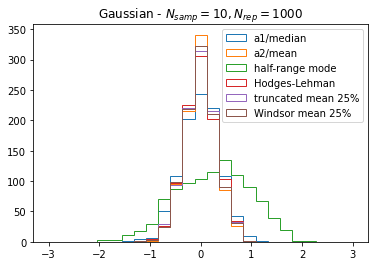

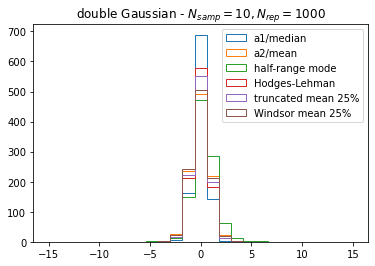

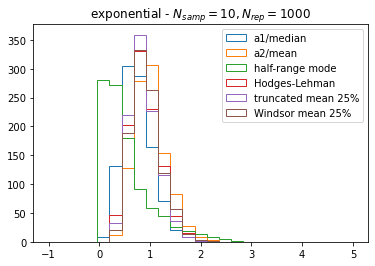

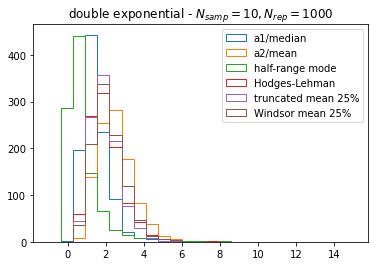

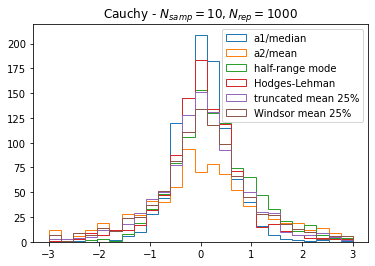

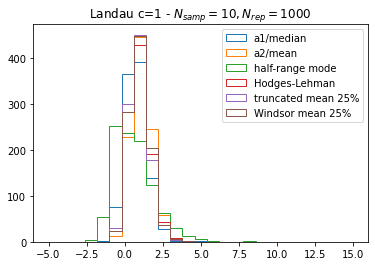

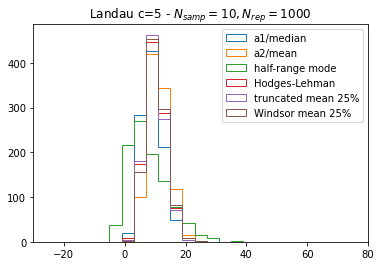

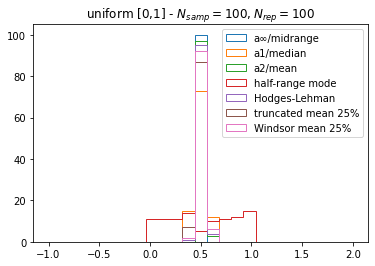

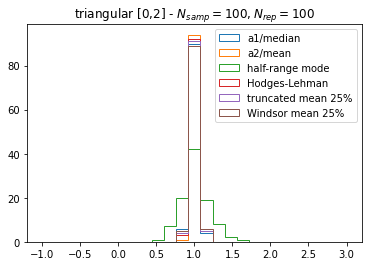

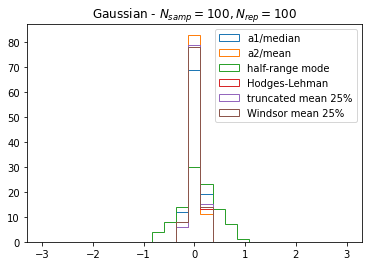

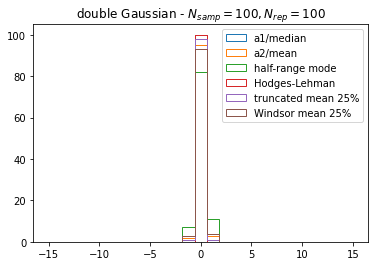

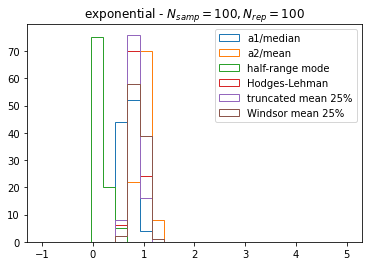

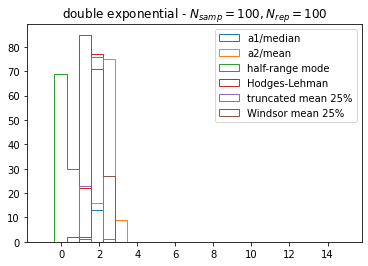

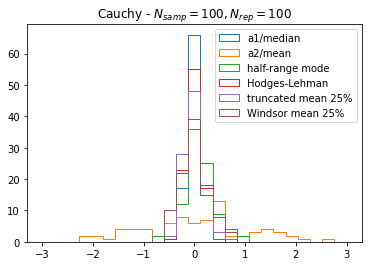

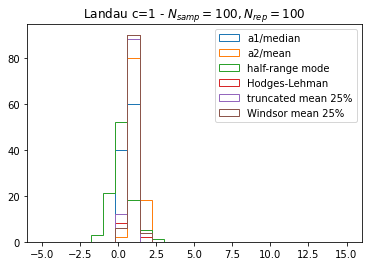

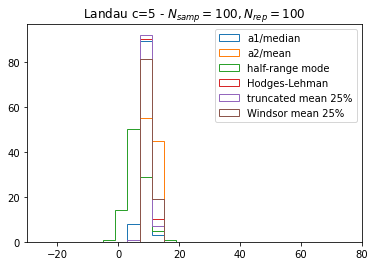

In [17]:
for n_samp in [10, 100]:
    results = res[n_samp][4]
    r = max(10000 // n_samp, 100)
    for dist, d in results.items():
        plt.figure()
        for est, est_res in d.items():
            if est in ['a-∞ mode', 'range mode', 'half-samples mode', 'truncated mean 10%', 'Windsor mean 10%']:
                continue
            if 'midrange' in est and 'uniform' not in dist:
                continue
            plt.hist(est_res, histtype='step', label=est,
                     range=ranges[dist], bins=25)
        plt.title(f"{dist} - $N_{{samp}}={n_samp:g}, N_{{rep}}={r:g}$")
        plt.legend(loc='upper right')
        plt.show()

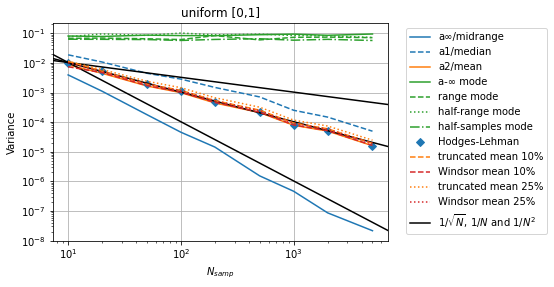

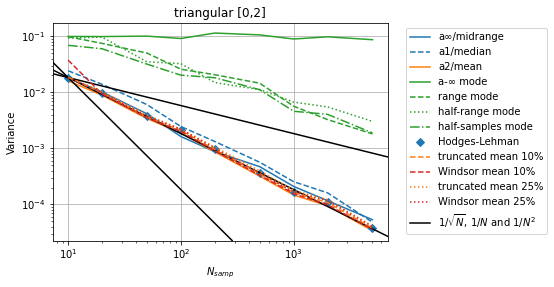

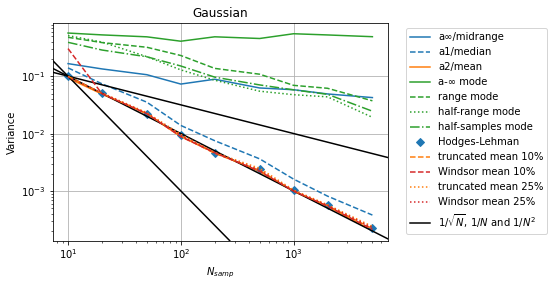

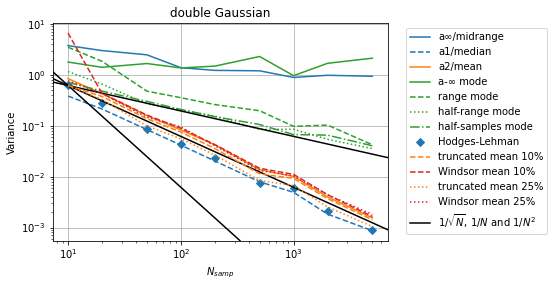

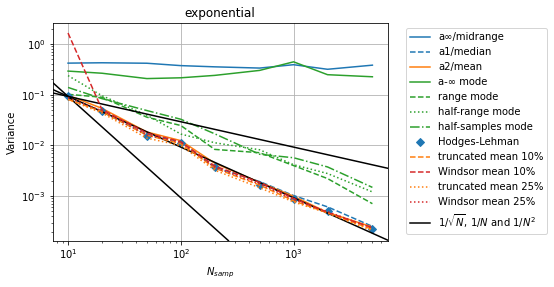

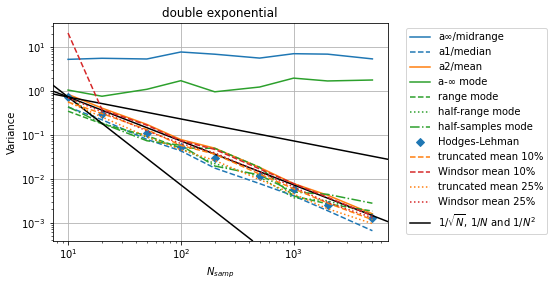

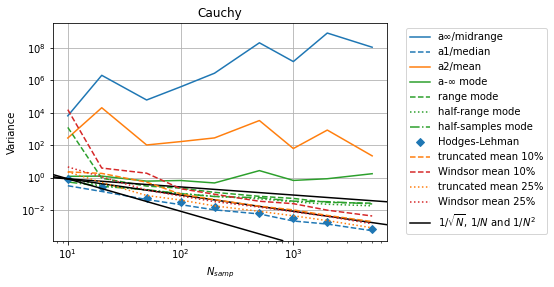

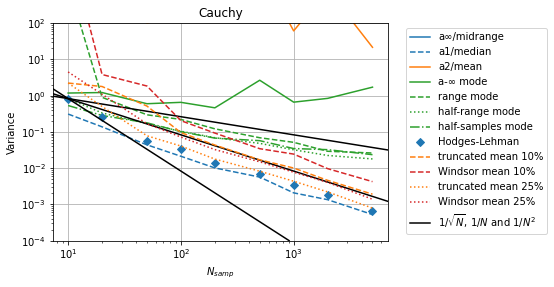

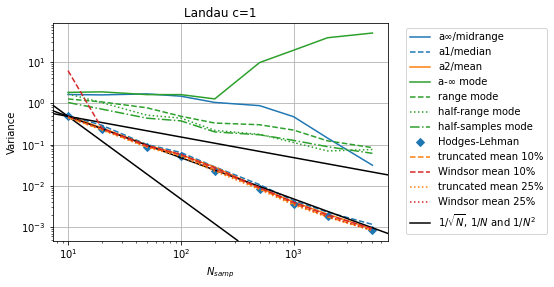

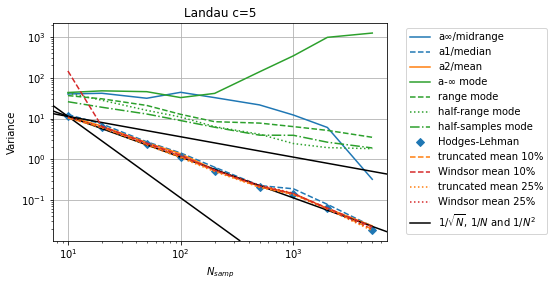

In [36]:
import matplotlib.lines as mlines
styles = {  # estimator: (line_style, color)
    "a∞/midrange": ('-', 'C0'),
    "a1/median": ('--', 'C0'),
    "a2/mean": ('-', 'C1'),
    "a-∞ mode": ('-', 'C2'),
    "range mode": ('--', 'C2'),
    "half-range mode": (':', 'C2'),
    "half-samples mode": ('-.', 'C2'),
    "Hodges-Lehman": ('D', 'C0'),
    "truncated mean 10%": ('--', 'C1'),
    "Windsor mean 10%": ('--', 'C3'),
    "truncated mean 25%": (':', 'C1'),
    "Windsor mean 25%": (':', 'C3')
}
variances = {
    dist: {
        est: {
            n_samp: v[dist][est]
            for n_samp, (v, _, _, _, _) in res.items()}
        for est in ESTIMATORS.keys()}
    for dist in DISTRIBUTIONS.keys()}
for dist, dist_vars in variances.items():
    for lims in [None, (1e-4,1e2)] if "Cauchy" in dist else [None]:
        lh = []
        for est, est_vars in dist_vars.items():
            lh.append(plt.loglog(est_vars.keys(), est_vars.values(),
                       styles[est][0], c=styles[est][1], label=est)[0])
            if "Hodg" in est:
                x, y = next(iter(est_vars.items()))
                plt.axline((x, y), (x*10, y/10), color='black')
                plt.axline((x, y), (x*100, y/10), color='black')
                plt.axline((x, y), (x*10, y/100), color='black')
        lh.append(mlines.Line2D(
            [], [], color='black',
            label='$1/\sqrt{N}$, $1/N$ and $1/N^2$'))
        plt.title(dist)
        plt.xlabel("$N_{samp}$")
        plt.ylabel("Variance")
        plt.legend(bbox_to_anchor=(1.04, 1), loc='upper left',
                   handles=lh)
        plt.grid()
        if lims is not None:
            plt.ylim(*lims)
        plt.show()

## Results
Here I proceed to show the results for the different estimators.

 - The midrange:
    - it is, by far, the best estimator for the uniform distribution (lowest variance of all, and $\sim 1/n^2$, which is expected from theory);
    - it performs as good as other estimators for the triangular ($\sim 1/n$);
    - it diverges for the Cauchy distribution; and
    - it performs rather poorly with all other distributions ($\sim 1/\sqrt{n}$ or constant, with larger variances than other estimators).
 - The $a_{-\infty}$ mode is constant or diverges for all distributions (it is, in fact, known for being numerically unstable).
 - The other mode-based estimators:
    - have high, constant variance for the uniform distribution (expected);
    - have $\sim 1/n$ variance with the exponential and double exponential distributions, althoug for the former they still perform worse than other estimators; and
    - have $\sim 1/\sqrt{n}$ variance for all other distributions.
 - The mean:
    - is the best estimator (or among the best estimators) for the uniform, triangular, Gaussian, exponential and Landau distributions (always $\sim 1/n$);
    - has constant and very high variance for the Cauchy (expected); and
    - is still $\sim 1/n$, but outperformed by other estimators, for the double Gaussian and double exponential.
 - The truncated and Windsorized means:
    - perform like the mean for the uniform, triangular, Gaussian, exponential, and Landau distributions (although the Windsorized mean tends to perform worse, especially at low $n$ and with small fraction of Windsorized samples);
    - perform $\sim 1/n$ like the mean, but better than the mean, for the double Gaussian and double exponential, with the Windsorized means being the worst, and the truncated mean with high truncated fraction ($r=0.25$) being the best; and
    - perform $\sim 1/n$ for the Cauchy, although there are better (still $\sim 1/n$) estimators.
 - The median:
    - is $\sim 1/n$ but performs worse than others for the uniform, triangular and Gaussian;
    - is $\sim 1/n$ and the best estimator (or among the best estimators) for the double Gaussian, exponential, double exponential, Cauchy and Landau.
 - The Hodges-Lehman estimator performs like the best estimator for all distributions except the uniform.

Summarizing.

- The midrange is the best estimator for uniform distributions; it is among the best for the triangular; but it is among the worst for other distributions.
 - The mean is the best estimator for non-heavy-tailed/non-mixed distributions, and also for the Landau; but it has worse performance with heavy-tailed distribution, and in particular for the Cauchy distribution;
 - The median and the Hodges-Lehman estimators are close to the best estimators for non-heavy-tailed/non-mixed distributions, and are the best estimators for heavy-tailed distributions.
 
The median and the Hodges-Lehman seem to be the best choice for unknown, possibly heavy-tailed distributions.
The Hodges-Lehman estimator is the best of the two, but it is computationally- and memory-expensive, which make its usage less feasible at high $n$.

|Estimator|Time (best)|Time (here)|Memory (best)|Memory (here)|
|:-:|:-:|:-:|:-:|:-:|
|Hodges-Lehman|$O(n^2)$*|$O(n^2\log{n})$|$n^2+n$|$2n^2+n$|
|Median|$O(n)$*|$O(n\log n)$|$n$|$n$|
|Mean|$O(n)$|$O(n)$|$n$|$n$|
|Midrange|$O(n)$|$O(n)$|$n$|$n$|
|Truncated/Windsorized mean|$O(n)$*|$O(n\log n)$|$n$|$n$|

Note that the best values for the best possible time complexity that have a * in the table can only be obtained if the samples are already sorted (or, at least, stored in a binary search tree or similar structure).
Also note the the mean and midrange (but not the truncated/Windsorized mean) have smaller complexity than the median (except in the best case).